In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sys
from tqdm import tqdm
sys.path.append('../../../src')

from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity
from common.default import PASSING_DEFAULT
from display.display import display
from individual_activity.individual_activity import IndividualActivity

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

In [3]:
seed = 64
np.random.seed(seed)

# Indivisual Activity をロード

In [4]:
data_settings = [
    {'room_num': '09', 'date': '20210304', 'option': 'passing'}
]

In [5]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [6]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [7]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '09', 'date': '20210304', 'option': 'passing'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.59it/s]


# SVM
## 特徴量抽出とデータ生成

In [8]:
def extract_features(frame_num, label1, label2, individuals):
    if label1 not in individuals or label2 not in individuals:
        return None
        
    individual1 = individuals[label1]
    pos1 = individual1.get_indicator('position', frame_num)
    body1 = individual1.get_indicator('body_vector', frame_num)
    arm1 = individual1.get_indicator('arm_ext', frame_num)
    wrist1 = [
        individual1.get_keypoints('LWrist', frame_num),
        individual1.get_keypoints('RWrist', frame_num)
    ]
    if pos1 is None or body1 is None or arm1 is None or None in wrist1:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_indicator('position', frame_num)
    body2 = individual2.get_indicator('body_vector', frame_num)
    arm2 = individual2.get_indicator('arm_ext', frame_num)
    wrist2 = [
        individual2.get_keypoints('LWrist', frame_num),
        individual2.get_keypoints('RWrist', frame_num)
    ]
    if pos2 is None or body2 is None or arm2 is None or None in wrist2:
        return None
    
    # ポジション間の距離
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig']
    )
    
    # 体の向き
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    p1p2 = pos2 - pos1
    p2p1 = pos1 - pos2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_direction = (np.average([p1_sim, p2_sim]) + 1) / 2  # [-1, 1] -> [0, 1]
    
    # 腕の上げ下げ
    arm_ave = np.average([arm1, arm2])
    
    # 手首の距離
    min_norm = np.inf
    for i in range(2):
        for j in range(2):
            norm = np.linalg.norm(
                np.array(wrist1[i]) - np.array(wrist2[j]), ord=2)
            if norm < min_norm:
                min_norm = norm
    distance_prob_wrist = gauss(
        min_norm,
        mu=PASSING_DEFAULT['wrist_gauss_mu'],
        sigma=PASSING_DEFAULT['wrist_gauss_sig']
    )

    return [distance_prob, body_direction, arm_ave, distance_prob_wrist]

columns = ['distance', 'body', 'arm', 'wrist']

In [9]:
x_dict = {}
y_dict = {}
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    dirs = sorted(glob.glob(f'{common.data_dir}/{room_num}/{date}/{opt}/*'))
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]

    for path in dirs:
        file_num = common.split_path(path)[-1]
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in tqdm(csv_data, desc=f'{room_num}, {date}, {file_num}'):
            frame_num = row[0]
            label1 = f'{room_num}_{file_num}_{row[1]}'
            label2 = f'{room_num}_{file_num}_{row[2]}'

            features = extract_features(frame_num, label1, label2, individuals)
            key = f'{room_num}_{file_num}_{row[1]}_{row[2]}'

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            if features is not None:
                x_dict[key].append(features)
                y_dict[key].append(row[3])

09, 20210304, 03: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7812/7812 [00:00<00:00, 21801.38it/s]


## 分布をプロット

In [168]:
def plot_feature(x_train, y_train, path=None):
    x_true = np.array(x_train)[np.where(np.array(y_train) == 1)].T
    x_false = np.array(x_train)[np.where(np.array(y_train) == 0)].T

    # 分布をプロット
    def set_ax(ax, column_i, column_j, title=None):
        if title is not None:
            ax.set_title(title)
        ax.set_xlabel(column_i)
        ax.set_ylabel(column_j)
        ax.set_xlim((0, 1))
        ax.set_xticks([0, 1])
        ax.set_ylim((0, 1))
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['', 1])

    n = int(len(columns) * (len(columns) - 1) / 2)  # 組み合わせ: len(columns) C 2

    fig = plt.figure(figsize=(10, n * 5))
    ax_count = 1
    for i in range(len(columns) - 1):
        for j in range(i + 1, len(columns)):
            ax = fig.add_subplot(n, 2, ax_count * 2 - 1)
            ax.scatter(x_true[i], x_true[j], color='red', s=1)
            if i == 0 and j == 1:
                set_ax(ax, columns[i], columns[j], 'Passing')
            else:
                set_ax(ax, columns[i], columns[j])

            ax = fig.add_subplot(n, 2, ax_count * 2)
            ax.scatter(x_false[i], x_false[j], s=1)
            if i == 0 and j == 1:
                set_ax(ax, columns[i], columns[j], 'Not Passing')
            else:
                set_ax(ax, columns[i], columns[j])

            ax_count += 1
            
    fig.subplots_adjust(hspace=0.3)
    if path is not None:
        fig.subplots_adjust(left=0.08, right=0.95, bottom=0.02, top=0.98)
        fig.savefig(path)

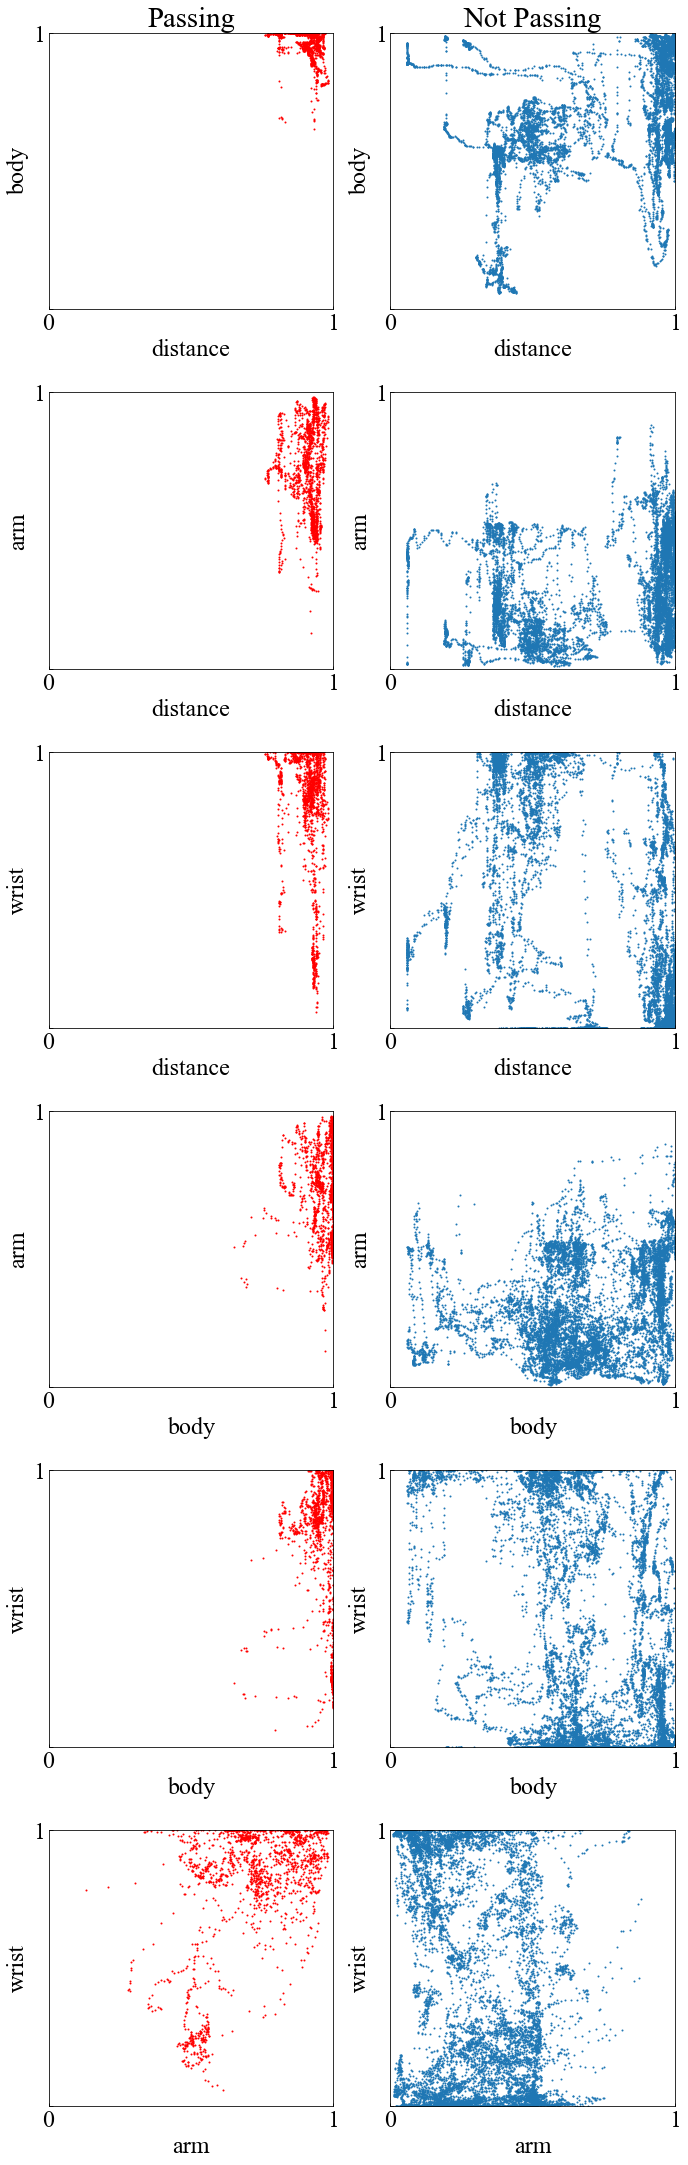

In [169]:
# データを整形
x_lst = []
y_lst = []
for x, y in zip(x_dict.values(), y_dict.values()):
    x_lst += x
    y_lst += y
path = os.path.join(common.data_dir, "image", "passing", 'features_sim.pdf')
plot_feature(x_lst, y_lst, path)

## 学習・検証

In [12]:
from sklearn.svm import SVC

from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
# import seaborn as sns
import pickle

## 模擬実験のモデルで検証

## データセット作成

In [13]:
x_train_dict = {key: val for key, val in x_dict.items() if "09_01" in key}
y_train_dict = {key: val for key, val in y_dict.items() if "09_01" in key}
x_train = []
y_train = []
for x, y in zip(x_train_dict.values(), y_train_dict.values()):
    x_train += x
    y_train += y

x_test1_dict = {key: val for key, val in x_dict.items() if "09_03" in key}
y_test1_dict = {key: val for key, val in y_dict.items() if "09_03" in key}
x_test1 = []
y_test1 = []
for x, y in zip(x_test1_dict.values(), y_test1_dict.values()):
    x_test1 += x
    y_test1 += y

x_test2_dict = {key: val for key, val in x_dict.items() if "09_02" in key}
y_test2_dict = {key: val for key, val in y_dict.items() if "09_02" in key}
x_test2 = []
y_test2 = []
for x, y in zip(x_test2_dict.values(), y_test2_dict.values()):
    x_test2 += x
    y_test2 += y

In [14]:
len_pass = len([i for i in y_lst if i == 1])
len_not_pass = len([i for i in y_lst if i == 0])

print(f'all length:{len(y_lst)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

all length:12979
passing: 1700
not passing: 11279


In [15]:
len_pass_train = len([i for i in y_train if i == 1])
len_not_pass_train = len([i for i in y_train if i == 0])

print(f'train length:{len(y_train)}')
print(f'passing: {len_pass_train}')
print(f'not passing: {len_not_pass_train}')

train length:1558
passing: 538
not passing: 1020


In [16]:
len_pass_test1 = len([i for i in y_test1 if i == 1])
len_not_pass_test1 = len([i for i in y_test1 if i == 0])

print(f'test length:{len(y_test1)}')
print(f'passing: {len_pass_test1}')
print(f'not passing: {len_not_pass_test1}')

test length:5355
passing: 447
not passing: 4908


In [17]:
len_pass_test2 = len([i for i in y_test2 if i == 1])
len_not_pass_test2 = len([i for i in y_test2 if i == 0])

print(f'test length:{len(y_test2)}')
print(f'passing: {len_pass_test2}')
print(f'not passing: {len_not_pass_test2}')

test length:6066
passing: 715
not passing: 5351


In [93]:
model = SVC(C=0.6, gamma=0.09)

model.fit(x_train, y_train)

SVC(C=0.6, gamma=0.09)

## モデルを保存

In [94]:
model_path = os.path.join(common.model_dir, 'pickle', 'pass_model_svm_ex0304.pickle')
with open(model_path, mode='wb') as f:
    pickle.dump(model, f)

## 検証

In [95]:
def plot(x_lst, y_lst, pred, path):
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_axes((0.04, 0.17, 0.80, 0.81))
    
    ax.plot(pred, label='pred')
    ax.plot(y_lst, linestyle=':', label='ground truth')
    for i, feature in enumerate(np.array(x_lst).T):
        ax.plot(feature, alpha=0.4, label=columns[i])

    ax.set_ylim((-0.05, 1.05))
    ax.set_xlabel('frame')
    ax.legend(
        bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0,
        fontsize=20, handlelength=0.8, handletextpad=0.2
    )
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    fig.savefig(path)
    plt.show()

09_01_1_2


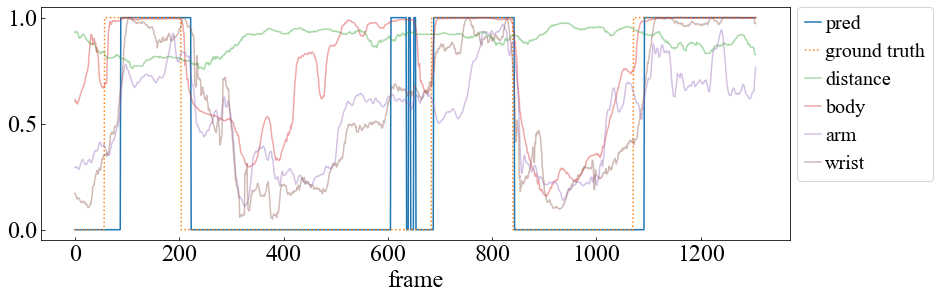

In [96]:
y_all_train = []
pred_all_train = []
y_eve_train = []
pred_eve_train = []

for key, x, y in zip(x_train_dict.keys(), x_train_dict.values(), y_train_dict.values()):
    pred = model.predict(x)
    
    y_all_train += y
    pred_all_train += pred.tolist()
    y_eve_train.append(1 in y)
    pred_eve_train.append(1 in pred.tolist())
    
    if len(x) == 0 or 1 not in y:
        continue
    
    print(key)
    path = os.path.join(common.data_dir, "image", "passing", "ex0304_train.pdf")
    plot(x, y, pred, path)

In [97]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_train, pred_all_train)))
print('precision: {:.3f}'.format(precision_score(y_all_train, pred_all_train)))
print('recall: {:.3f}'.format(recall_score(y_all_train, pred_all_train)))
print('f1_score: {:.3f}'.format(f1_score(y_all_train, pred_all_train)))

accuracy: 0.924
precision: 0.886
recall: 0.896
f1_score: 0.891


In [98]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_train, pred_eve_train)))
print('precision: {:.3f}'.format(precision_score(y_eve_train, pred_eve_train)))
print('recall: {:.3f}'.format(recall_score(y_eve_train, pred_eve_train)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_train, pred_eve_train)))

accuracy: 0.667
precision: 0.500
recall: 1.000
f1_score: 0.667


09_03_0_1


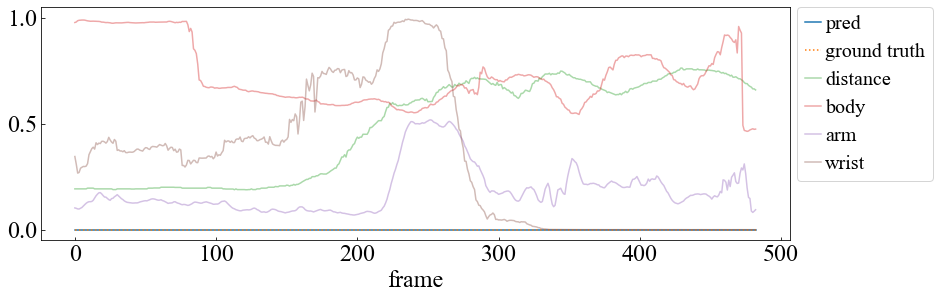

09_03_0_2


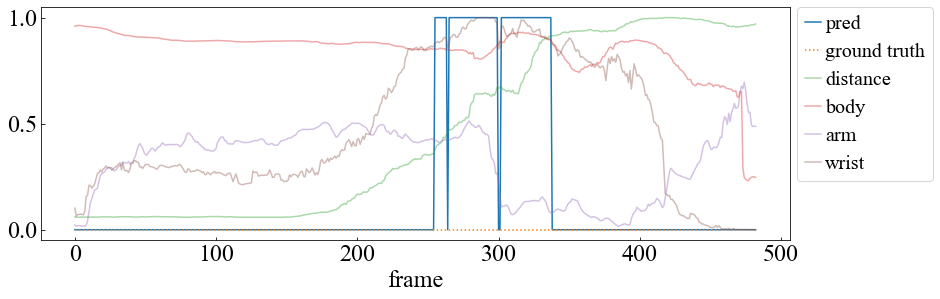

09_03_0_3


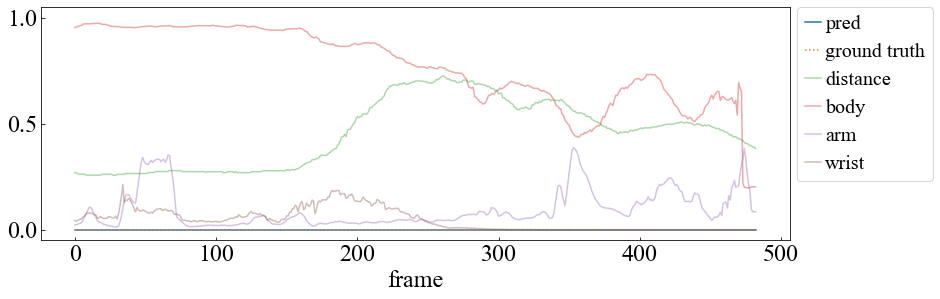

09_03_1_2


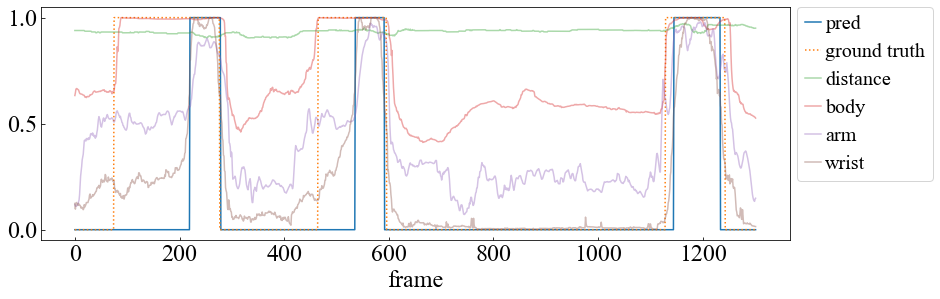

09_03_1_3


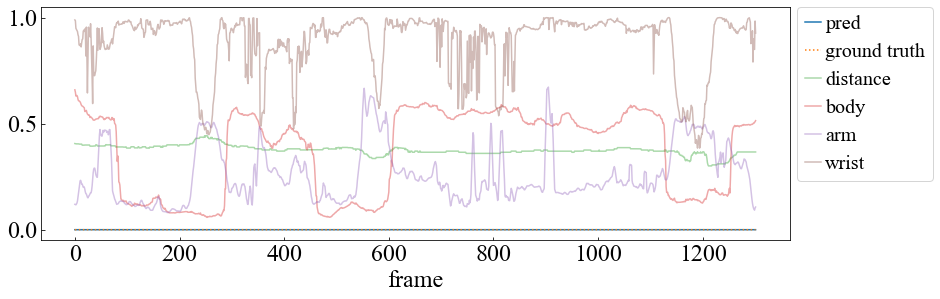

09_03_2_3


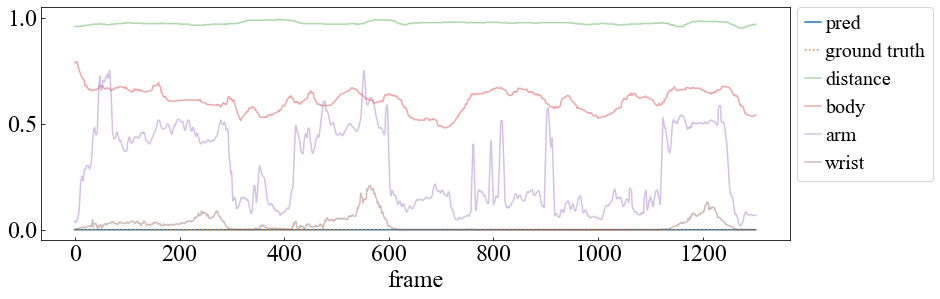

In [99]:
y_all_test = []
pred_all_test = []
y_eve_test = []
pred_eve_test = []

for key, x, y in zip(x_test1_dict.keys(), x_test1_dict.values(), y_test1_dict.values()):
    pred = model.predict(x)
    
    y_all_test += y
    pred_all_test += pred.tolist()
    y_eve_test.append(1 in y)
    pred_eve_test.append(1 in pred.tolist())
    
    # if len(x) == 0 or 1 not in y:
    #     continue
        
    print(key)
    path = os.path.join(common.data_dir, "image", "passing", f"ex0304_test1_{key}.pdf")
    plot(x, y, pred, path)

In [100]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_test, pred_all_test)))
print('precision: {:.3f}'.format(precision_score(y_all_test, pred_all_test)))
print('recall: {:.3f}'.format(recall_score(y_all_test, pred_all_test)))
print('f1_score: {:.3f}'.format(f1_score(y_all_test, pred_all_test)))

# cm = confusion_matrix(y_all_test, pred_all_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.939
precision: 0.711
recall: 0.452
f1_score: 0.553


In [101]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_test, pred_eve_test)))
print('precision: {:.3f}'.format(precision_score(y_eve_test, pred_eve_test)))
print('recall: {:.3f}'.format(recall_score(y_eve_test, pred_eve_test)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_test, pred_eve_test)))

# cm = confusion_matrix(y_eve_test, pred_eve_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.833
precision: 0.500
recall: 1.000
f1_score: 0.667


09_02_0_1


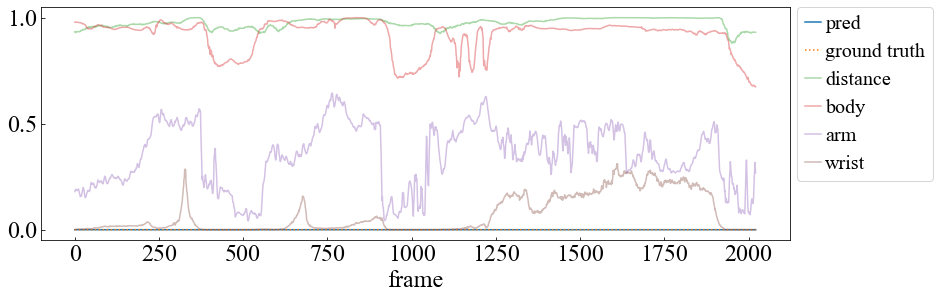

09_02_0_2


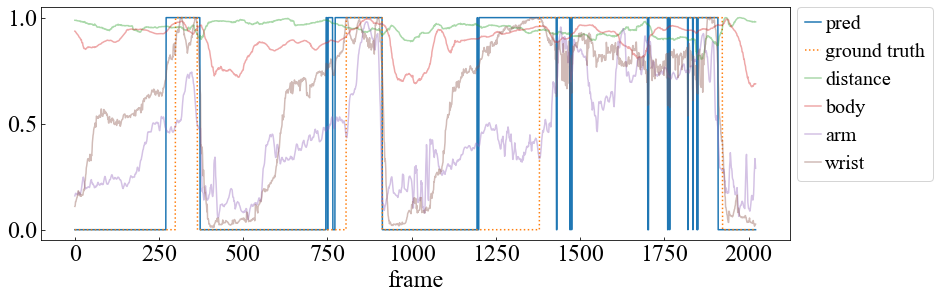

09_02_1_2


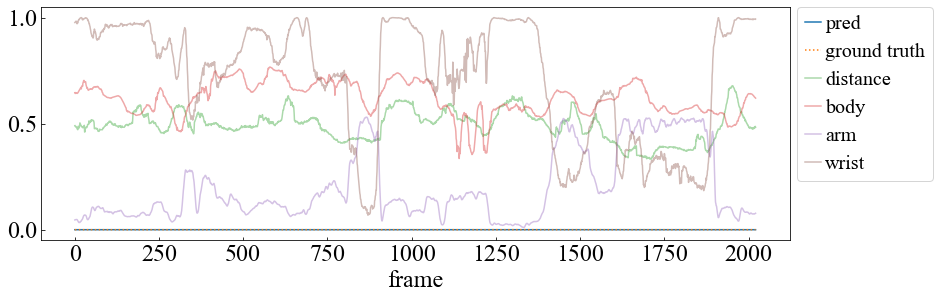

In [102]:
y_all_test = []
pred_all_test = []
y_eve_test = []
pred_eve_test = []

for key, x, y in zip(x_test2_dict.keys(), x_test2_dict.values(), y_test2_dict.values()):
    pred = model.predict(x)
    
    y_all_test += y
    pred_all_test += pred.tolist()
    y_eve_test.append(1 in y)
    pred_eve_test.append(1 in pred.tolist())
    
    # if len(x) == 0 or 1 not in y:
    #     continue
        
    print(key)
    path = os.path.join(common.data_dir, "image", "passing", f"ex0304_test2_{key}.pdf")
    plot(x, y, pred, path)

In [103]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_test, pred_all_test)))
print('precision: {:.3f}'.format(precision_score(y_all_test, pred_all_test)))
print('recall: {:.3f}'.format(recall_score(y_all_test, pred_all_test)))
print('f1_score: {:.3f}'.format(f1_score(y_all_test, pred_all_test)))

# cm = confusion_matrix(y_all_test, pred_all_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.951
precision: 0.719
recall: 0.961
f1_score: 0.823


In [104]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_test, pred_eve_test)))
print('precision: {:.3f}'.format(precision_score(y_eve_test, pred_eve_test)))
print('recall: {:.3f}'.format(recall_score(y_eve_test, pred_eve_test)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_test, pred_eve_test)))

# cm = confusion_matrix(y_eve_test, pred_eve_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 1.000
precision: 1.000
recall: 1.000
f1_score: 1.000


# パラメータ調整

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, log_loss
from tqdm import tqdm

In [80]:
params = {
    'C': np.arange(0.5, 10.1, 0.1),
    'gamma': np.arange(0.01, 1.0, 0.01)
}

x_test = x_test1 + x_test2
y_test = y_test1 + y_test2

max_score = 0
min_score = np.inf
auc_param = {}
logloss_param = {}
for c in tqdm(params['C']):
    for gamma in params['gamma']:
        model = SVC(C=c, gamma=gamma)
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        
        score = roc_auc_score(pred, y_test)
        if score > max_score:
            max_score = score
            auc_param = {'C': c, 'gamma': gamma}
            
        score = log_loss(pred, y_test)
        if score < min_score:
            min_score = score
            logloss_param = {'C': c, 'gamma': gamma}
            
print('max auc score: {}, C: {}, gamma: {}'.format(max_score, auc_param['C'], auc_param['gamma']))
print('min logloss score: {}, C: {}, gamma: {}'.format(min_score, logloss_param['C'], logloss_param['gamma']))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [26:00<00:00, 15.61s/it]

max auc score: 0.8478911100489143, C: 0.7, gamma: 0.09999999999999999
min logloss score: 1.8840623399113745, C: 0.6, gamma: 0.09
